In [1]:
import tensorflow as tf
import os.path
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [2]:
data_dir = r"C:\Users\Vinnie\Documents\Data2\Tuberculosis"

In [3]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [4]:
os.listdir(r"C:\Users\Vinnie\Documents\Data2\Tuberculosis")

['Normal', 'Tuberculosis']

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
#Remove Dodgy Images
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [7]:
Data = tf.keras.utils.image_dataset_from_directory(r"C:\Users\Vinnie\Documents\Data2\Tuberculosis")

Found 4200 files belonging to 2 classes.


In [8]:
Data_iterator = Data.as_numpy_iterator()

In [9]:
batch = Data_iterator.next()

In [10]:
len(batch)

2

In [11]:
batch[0].shape

(32, 256, 256, 3)

In [12]:
batch[1]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

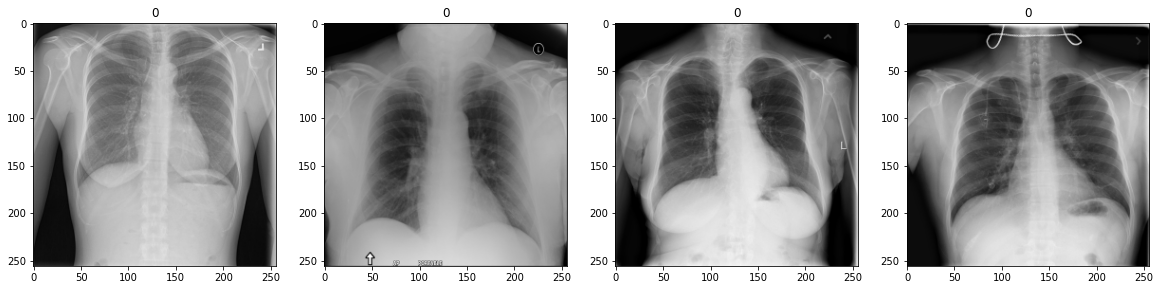

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
scaled = batch[0] / 255

In [15]:
scaled.max()

1.0

In [16]:
Data = Data.map(lambda x,y: (x/255, y))

In [17]:
scaled_iterator = Data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

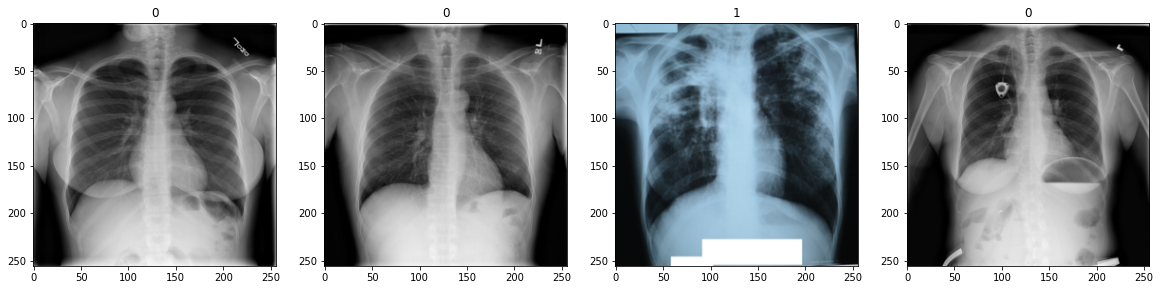

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [20]:
len(Data)

132

In [21]:
train_size = int(len(Data)*.7)
val_size = int(len(Data)*.2)
test_size = int(len(Data)*.1)

In [22]:
train_size

92

In [23]:
val_size

26

In [24]:
test_size

13

In [25]:
train = Data.take(train_size)
val = Data.skip(train_size).take(val_size)
test = Data.skip(train_size+val_size).take(test_size)

In [26]:
model = Sequential()

In [27]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [30]:
logdir='logs'

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
92/92 [==============================] - 59s 631ms/step - loss: 0.2546 - accuracy: 0.8886 - val_loss: 0.1536 - val_accuracy: 0.9315
Epoch 2/20
92/92 [==============================] - 59s 641ms/step - loss: 0.1187 - accuracy: 0.9586 - val_loss: 0.1035 - val_accuracy: 0.9724
Epoch 3/20
92/92 [==============================] - 60s 643ms/step - loss: 0.1202 - accuracy: 0.9545 - val_loss: 0.1144 - val_accuracy: 0.9651
Epoch 4/20
92/92 [==============================] - 59s 632ms/step - loss: 0.0790 - accuracy: 0.9755 - val_loss: 0.0799 - val_accuracy: 0.9760
Epoch 5/20
92/92 [==============================] - 60s 646ms/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.0755 - val_accuracy: 0.9796
Epoch 6/20
92/92 [==============================] - 59s 641ms/step - loss: 0.0468 - accuracy: 0.9840 - val_loss: 0.0763 - val_accuracy: 0.9760
Epoch 7/20
92/92 [==============================] - 59s 640ms/step - loss: 0.0289 - accuracy: 0.9918 - val_loss: 0.0747 - val_accuracy: 0.9760

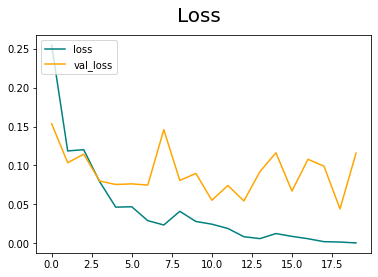

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

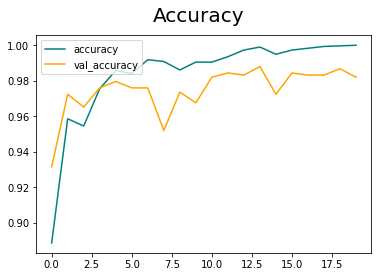

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [35]:
hist1 = model.fit(test, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
13/13 [==============================] - 16s 1s/step - loss: 0.1389 - accuracy: 0.9615 - val_loss: 0.0957 - val_accuracy: 0.9675
Epoch 2/20
13/13 [==============================] - 16s 1s/step - loss: 0.0787 - accuracy: 0.9832 - val_loss: 0.0799 - val_accuracy: 0.9796
Epoch 3/20
13/13 [==============================] - 16s 1s/step - loss: 0.0438 - accuracy: 0.9856 - val_loss: 0.0741 - val_accuracy: 0.9784
Epoch 4/20
13/13 [==============================] - 16s 1s/step - loss: 0.0642 - accuracy: 0.9832 - val_loss: 0.0771 - val_accuracy: 0.9796
Epoch 5/20
13/13 [==============================] - 17s 1s/step - loss: 0.0209 - accuracy: 0.9952 - val_loss: 0.0691 - val_accuracy: 0.9784
Epoch 6/20
13/13 [==============================] - 16s 1s/step - loss: 0.0853 - accuracy: 0.9760 - val_loss: 0.0348 - val_accuracy: 0.9880
Epoch 7/20
13/13 [==============================] - 17s 1s/step - loss: 0.0650 - accuracy: 0.9856 - val_loss: 0.0627 - val_accuracy: 0.9748
Epoch 8/20
13/13 [==

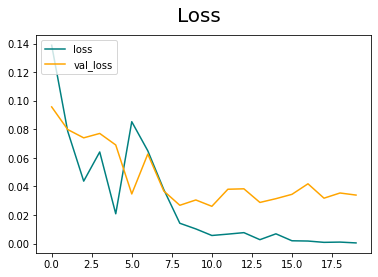

In [38]:
fig = plt.figure()
plt.plot(hist1.history['loss'], color='teal', label='loss')
plt.plot(hist1.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

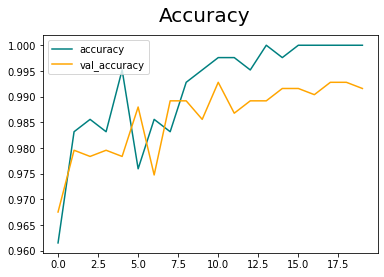

In [39]:

fig = plt.figure()
plt.plot(hist1.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist1.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [40]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [41]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [42]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 107ms/step


In [43]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.98717946, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.99759614, shape=(), dtype=float32)


In [44]:
len(test)

13

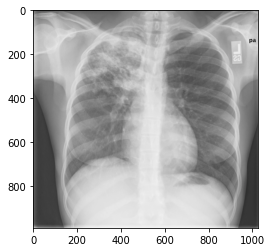

In [57]:
img = cv2.imread(r"C:\Users\Vinnie\Documents\Data2\Tuberculosis\TuberculosisTEST.webp")
plt.imshow(img)
plt.show()

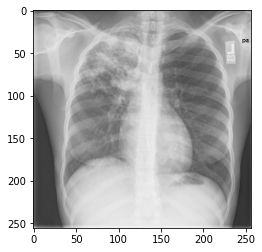

In [58]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [59]:
Tuberculosis_Test = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 29ms/step


In [60]:
if Tuberculosis_Test > 0.5: 
    print(f'Predicted class is Tuberculosis')
else:
    print(f'Predicted class is Normal')

Predicted class is Normal


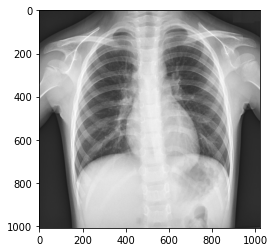

In [51]:
img = cv2.imread(r"C:\Users\Vinnie\Documents\Data2\Tuberculosis\NORMALTEST.jpeg")
plt.imshow(img)
plt.show()

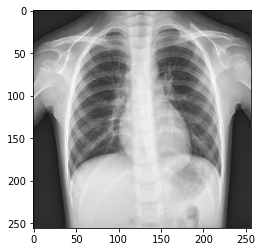

In [52]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [53]:
Normal_Test = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 30ms/step


In [56]:
if Normal_Test > 0.5: 
    print(f'Predicted class is Normal')
else:
    print(f'Predicted class is Tuberculosis')

Predicted class is Tuberculosis
